# imports

In [1]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

sys.path.append('..')
import data_transforations as data_tr


In [2]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/Data2/"

## Models

In [3]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedRandomForestClassifier



## Scoring

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Recall

In [5]:
#cross_val_score(clf, X, y, cv=5, scoring='recall')

#cv= the number of folds in cross validation

### Precision

In [6]:
#cross_val_score(clf, X, y, cv=5, scoring='precision')

### F-beta 

F1 score but you can choose the weighting between recall and precision, where f1 is 50:50

In [7]:
#fbeta_scorer = make_scorer(fbeta_score, beta=2) 
#in model fitting: scoring=fbeta_scorer
##cross_val_score(clf, X, y, cv=5, scoring=fbeta_scorer)
# beta is the ratio of recall:precision, so beta=2 means rcall2:1precision and beta =0.5 means recall1:2precision

### Functions

In [8]:
def lead_prov_grouping(prov):
    if prov in ['Recycled Freemium', 'SPL-Freemium', 'Sold Freemium','Quoted Freemium', 'ABBY Freemium', 'Freemium','CellC-Freemium']:
        return 'Freemium'
    elif prov in ['LeadWarming', 'LeadWarming TN ', 'Lead Warming']:
        return 'LeadWarming'
    elif prov in ['BLDS 101', 'BLDS']:
        return 'BLDS'
    elif prov in ['SD Phone Leads','MWL Phone Leads', 'iTalk External Call Center']:
        return 'Phone leads'
    elif prov in ['Sanlam Direct Cape Referral', 'SDC-Referral', 'MWL Referrals']:
        return 'Refferals'
    elif prov in ['Website',  'Bing', 'SD Web','MWL Web', 'Sanlam Digital','GoogleDisplay','GoogleSearch']:
        return 'Web'
    elif prov in ['MiWayLife', 'Sure_Strat_MWL','Existing Client','Reach_Republic_MWL', 'Newsletter']:
        return 'MWL'
    elif prov in ['Lead-D365-Production', 'Sanlam-Lead-D365-Production']:
        return 'D365'
    elif prov in ['Recycled','Facebook', 'Reinstatement', 'Vicidial','Wills', 'Affiliate', 'Sanlam Direct Cape', 'LiveLeads','SEO',
       'Competitions', 'SDC HIV','Olico']:
        return 'Other'
    else:
        return 'Other'


In [9]:
def data_prep(data,target,features=[],filter=None,column_excl = ['1month_lapse', '3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name','lead_provider_name','campaign_name','occupation'],cat_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_provider_groups', 'lead_type', 'sales_channel','hiv_group', 'securitygroup_id', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band','underwriting_outcome']):

    if filter is not None:
        data = data[data[filter].notnull()].copy()
    # impute missing values
    # impute missing values
    df=DataPreparation(df=data)
    imp_dict={'optionality': 'mode','cover_amount_full':'mean'}
    df.imputating_nulls(imp_dict=imp_dict)
    data=df.imputed_df.copy()
    #grouping lead-provider_name
    data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)
    data.drop(columns=['lead_provider_name'],inplace=True)
    cat_cols.append('lead_provider_groups')
    data=pd.get_dummies(data,columns=cat_cols, dtype=int)
    if features == []:
        cols=set(data.columns)
        features=list(cols.difference(column_excl))
         
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    # Train Test Split
    X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, Y_train, y_test


# Modelling

In [10]:
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

Target = ['3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse' 'lapse_flag']

### Data for modeling

In [11]:
imp_features=[]
target= '6month_lapse'
#filter='ann_lapse'
data=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
data=data.drop(columns=['Unnamed: 0','occupation','campaign_name','hiv_group'])#,'Unnamed: 0.1','policy_type'])
class_weight = {0:1,1:1}


In [26]:
data.columns

Index(['policy_name', 'age', 'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'lead_provider_name',
       'lead_type', 'sales_channel', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'eml', 'pml', 'securitygroup_id', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment rate',
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band'],
      dtype='object')

In [12]:
data[target].sum()*100/data[target].count()

27.44448424068768

In [30]:
data_info=DataPreparation(df=data)

In [31]:
data_info.null_df

,nulls,percentage nulls
policy_name,0,0.000000
age,0,0.000000
education,0,0.000000
gender,0,0.000000
income,0,0.000000
smoker_status,0,0.000000
sold_socio_economic_class,0,0.000000
occupation_class,0,0.000000
lead_provider_name,0,0.000000
lead_type,0,0.000000


In [32]:
data_info.uniq_df

,no. of unique entries
policy_name,22336
age,47
education,7
gender,2
income,1710
smoker_status,3
sold_socio_economic_class,4
occupation_class,5
lead_provider_name,44
lead_type,6


### Scaling data

In [13]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
data_s=data.copy()

In [14]:
data_s[[ 'age',  'income',  'eml','pml',  'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum','inflation', 'unemployment rate']] = scale.fit_transform(data_s[[ 'age',  'income',  'eml','pml',  'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum','inflation', 'unemployment rate']])



In [15]:

data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel','age',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)



In [16]:
data_s.columns

Index(['policy_name', 'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'lead_provider_name',
       'lead_type', 'optionality', 'hiv_test_required', 'eml', 'pml',
       'benefits_count', 'last_benefit_amount', 'cover_amount_full',
       'total_funeral_premium', 'funeral_count', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment rate',
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse', 'age_band',
       'original_premium_band'],
      dtype='object')

In [53]:
data=data_s.copy()
target='6month_lapse'
print(data[target].sum()*100/data[target].count())

X_train,x_test, Y_train, y_test = data_prep(data,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_type', 'hiv_test_required', 'age_band',
        'original_premium_band'])

27.44448424068768


### Enriching data

In [18]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
data = data_s.copy()
reins_data = pd.DataFrame(pd.read_csv(path+"reinsurance_data.csv"))
reins_inc_data = multi_data_ops(file_list=[],df1=data,df2=reins_data)
reins_inc_data.df_merged = reins_inc_data.merging(on='policy_name', how='left', df_left=reins_inc_data.df1, df_right=reins_inc_data.df2,col_right=['policy_name','has_additional_lives', 'num_additional_lives',
        'has_Child', 'has_Extended', 'has_Parent', 'has_Spouse'])
reins_inc_data.df_merged=reins_inc_data.df_merged[reins_inc_data.df_merged['has_Child'].notnull()]

In [19]:
enriched_1=reins_inc_data.df_merged
enriched_1['has_Child'] = enriched_1['has_Child'].apply(lambda x: False if x=='0' else x).astype(bool)
enriched_1['has_Extended'] =enriched_1['has_Extended'].apply(lambda x: False if x=='0' else x).astype(bool)
enriched_1['has_Parent'] = enriched_1['has_Parent'].apply(lambda x: False if x=='0' else x).astype(bool)
enriched_1['has_Spouse'] = enriched_1['has_Spouse'].apply(lambda x: False if x=='0' else x).astype(bool)

In [20]:
path = "C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/"
enrich_data = pd.read_excel(path+"MiWay_Life_Clients_Enrichments (with opt out) (1).xlsx", sheet_name='Overlapping clients')
data=data_s.copy()
id_data = pd.read_csv(path+"id_number_data.csv")
enrich_inc_data = multi_data_ops(file_list=[],df1=data,df2=enrich_data,df3=id_data)
inc_id_data = enrich_inc_data.merging(on='policy_name',df_left=enrich_inc_data.df1,df_right=enrich_inc_data.df3,how='left',col_right=['policy_name','id_number'])
enrich_inc_data.df_merged = enrich_inc_data.merging(left_on='id_number',right_on='ID_Number    ',df_left=inc_id_data,df_right=enrich_inc_data.df2,how='left',col_right=['ID_Number    ','FAS_group', 'Client_Experince_Segment', 'Credit_Score_Band', 'Home_Owner'])
enrich_inc_data.df_merged=enrich_inc_data.df_merged[enrich_inc_data.df_merged['ID_Number    '].notnull()]

In [21]:
enriched_2=enrich_inc_data.df_merged

In [33]:
enriched_2['Home_Owner'].unique()

array(['Yes       ', 'No        ', 'Unknown   '], dtype=object)

In [34]:
enriched_2.columns

Index(['policy_name', 'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'lead_provider_name',
       'lead_type', 'optionality', 'hiv_test_required', 'eml', 'pml',
       'benefits_count', 'last_benefit_amount', 'cover_amount_full',
       'total_funeral_premium', 'funeral_count', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment rate',
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse', 'age_band',
       'original_premium_band', 'id_number', 'ID_Number    ', 'FAS_group',
       'Client_Experince_Segment', 'Credit_Score_Band', 'Home_Owner'],
      dtype='object')

In [22]:
all_enriched = reins_inc_data.df_merged.merge(enrich_inc_data.df_merged,how='inner',on='policy_name')

In [79]:
data=enriched_2
target='ann_lapse'
print(data[target].sum()*100/data[target].count())
X_train,x_test, Y_train, y_test = data_prep(data,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse',
       'id_number', 'ID_Number    '],cat_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_type', 'hiv_test_required', 'age_band',
        'original_premium_band',
        'FAS_group',
       'Client_Experince_Segment', 'Credit_Score_Band', 'Home_Owner'],filter='ann_lapse')

14.837712519319938


In [89]:
enriched_2.shape

(6613, 44)

In [45]:
X_train.dtypes

original_premium_band_< 280.76             int32
duration_policy_start_delay              float64
lead_provider_groups_Web                   int32
age_band_38.50 - 43.50                     int32
res_code_quote_sum                       float64
                                          ...   
smoker_status_S                            int32
age_band_< 32.50                           int32
lead_type_Affiliate                        int32
original_premium_band_280.76 - 385.28      int32
pml                                      float64
Length: 75, dtype: object

### resampling SMOTE

In [54]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy=0.5,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())

#X_train=X_smote.copy()
#Y_train=Y_smote.copy()

In [55]:
Y_smote.sum()*100/Y_smote.count()

33.333333333333336

### Random Forest

In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(700,4000),
              'class_weight': [{0:1,1:1.2},{0:1,1:4},{0:1,1:1.6},{0:1,1:8}]}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring=scorer, random_state=42) #'recall',fbeta_scorer, custom_scorer

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

best score 1.0
 best eatimator RandomForestClassifier(class_weight={0: 1, 1: 8}, min_samples_leaf=3619,
                       n_estimators=201)
 best params {'class_weight': {0: 1, 1: 8}, 'min_samples_leaf': 3619, 'n_estimators': 201}
 


In [111]:
n_estimators=rand_search.best_params_['n_estimators']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
class_weight=rand_search.best_params_['class_weight']

rfc = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42,class_weight=class_weight)
recall = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
fb = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(rfc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb} \n custom score {cs}')




recall score [1. 1. 1. 1. 1.]
 precision score [0.41166804 0.41166804 0.41187346 0.41175262 0.41175262]
 f beta score [0.69457182 0.69457182 0.69475171 0.6946459  0.6946459 ] 
 custom score [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667]


In [112]:
rfc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = rfc.predict(x_test)

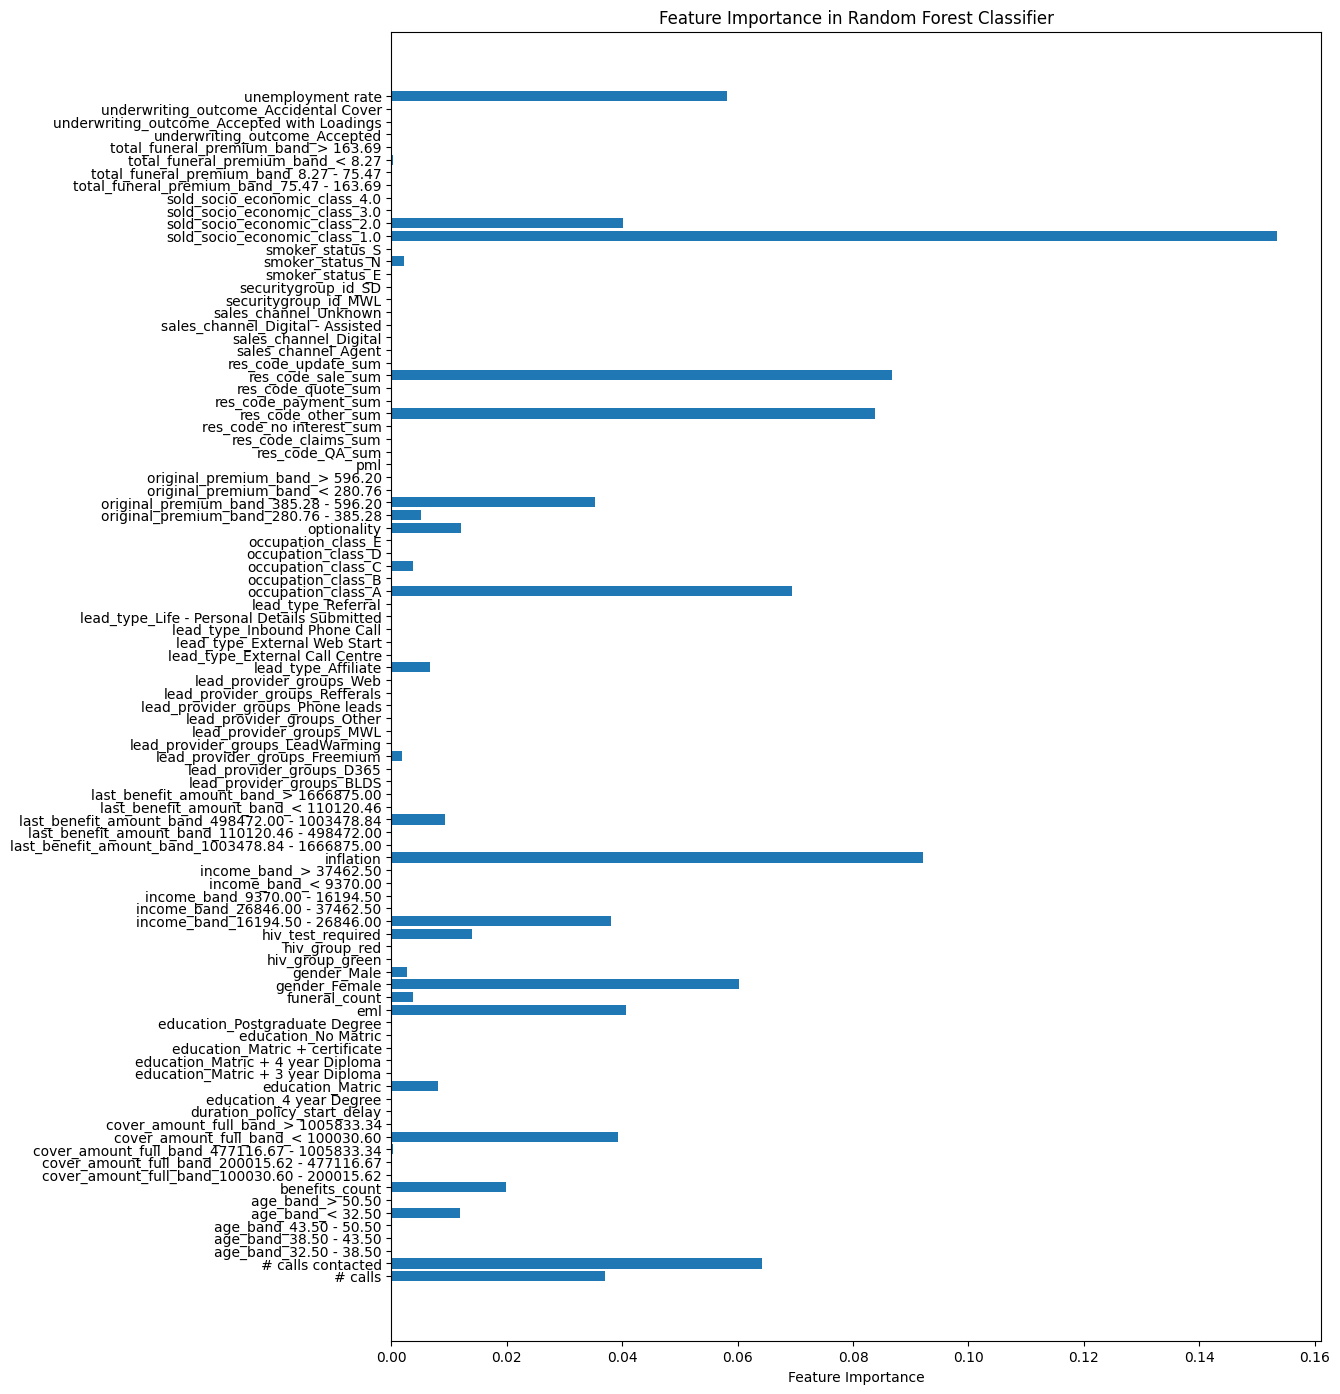

In [113]:
feature_importances =rfc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


#useless_feat=['underwriting_outcome', securitygroup_id','sales_channel',hiv_group']

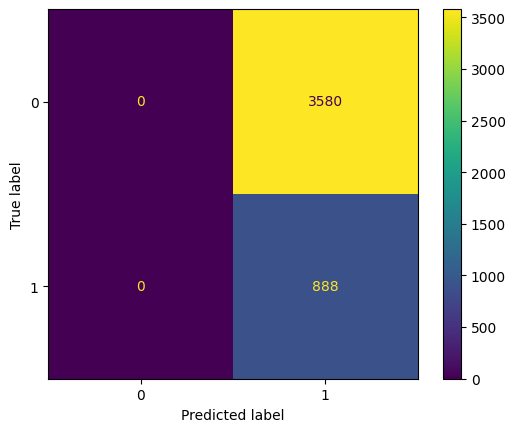

In [114]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


### Balanced Random Forest

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [42]:
X_train_n=  X_smote.copy()#X_train.copy()#X_smote.copy()
Y_train_n= Y_smote.copy() #Y_train.copy()#Y_smote.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'n_estimators': randint(50,500),
              'min_samples_leaf': randint(700,4000)}

# Create a balanced random forest classifier
brf = BalancedRandomForestClassifier(random_state=42)

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(brf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 scoring=scorer, random_state=42) #'recall',fbeta_scorer

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

best score 0.664254690178401
 best eatimator BalancedRandomForestClassifier(min_samples_leaf=830, n_estimators=199,
                               random_state=42)
 best params {'min_samples_leaf': 830, 'n_estimators': 199}
 


In [57]:
n_estimators=rand_search.best_params_['n_estimators']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']

brfc = BalancedRandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, random_state=42)
recall = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=1.5) 
fb = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(brfc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

recall score [0.51164144 0.52328289 0.75203725 0.7636787  0.73457509]
 precision score [0.50838635 0.50992626 0.55426855 0.56140351 0.55865427]
 f beta score [0.51063545 0.51909923 0.6776406  0.68746473 0.66968732]
 custom score [0.57549839 0.58162993 0.71372282 0.72311378 0.70697135]


In [58]:
brfc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = brfc.predict(x_test)

c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\E1005279\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p

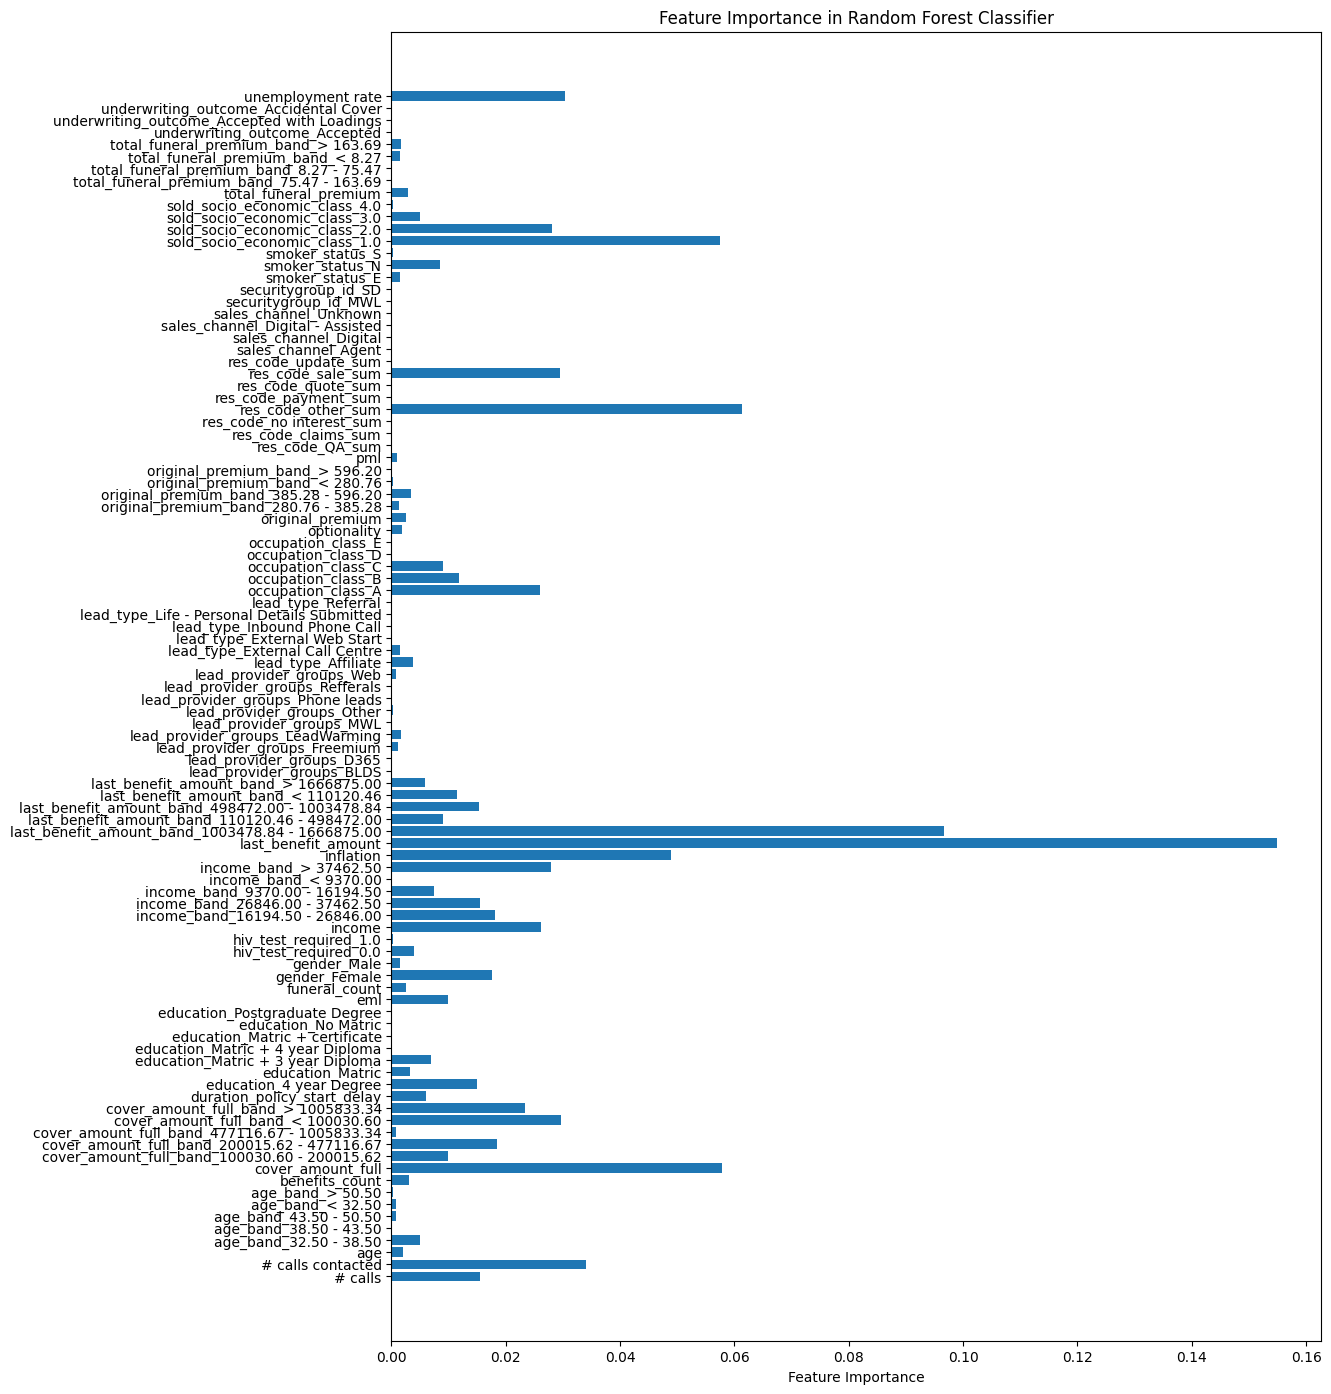

In [ ]:
feature_importances =brfc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()


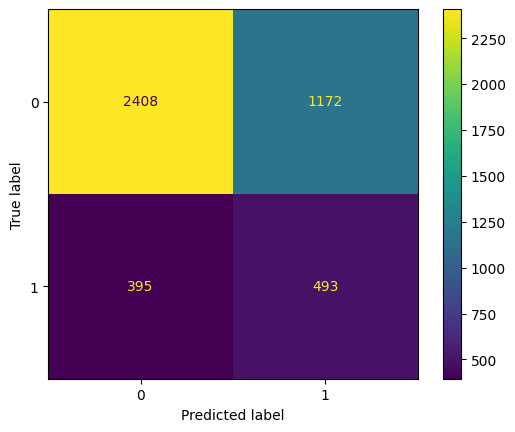

In [60]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()


### XGBoost

In [56]:
#X_train_n=X_train.copy()
#Y_train_n=Y_train.copy()
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=30,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B561F5A0C0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B5628C2BA0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B562EF6A20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001B562D644D0>},
                   random_state=42,
                   scoring=make_scorer(my_custom_accuracy, response_method='predict'))

In [57]:
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight

In [58]:
print(rand_search.best_params_ )
print(rand_search.best_score_)

{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1402, 'n_estimators': 195}
0.7584761869970518


In [59]:
n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

recall = cross_val_score(xgbc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

recall score [0.64225135 0.65277778 0.65432099 0.70756173 0.83577487]
 precision score [0.73782108 0.73629243 0.7399651  0.74613507 0.74655647]
 f beta score [0.68672712 0.69202454 0.69451269 0.72633663 0.78865042]
 custom score [0.72344974 0.7295675  0.73123906 0.76493317 0.84319147]


In [60]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)


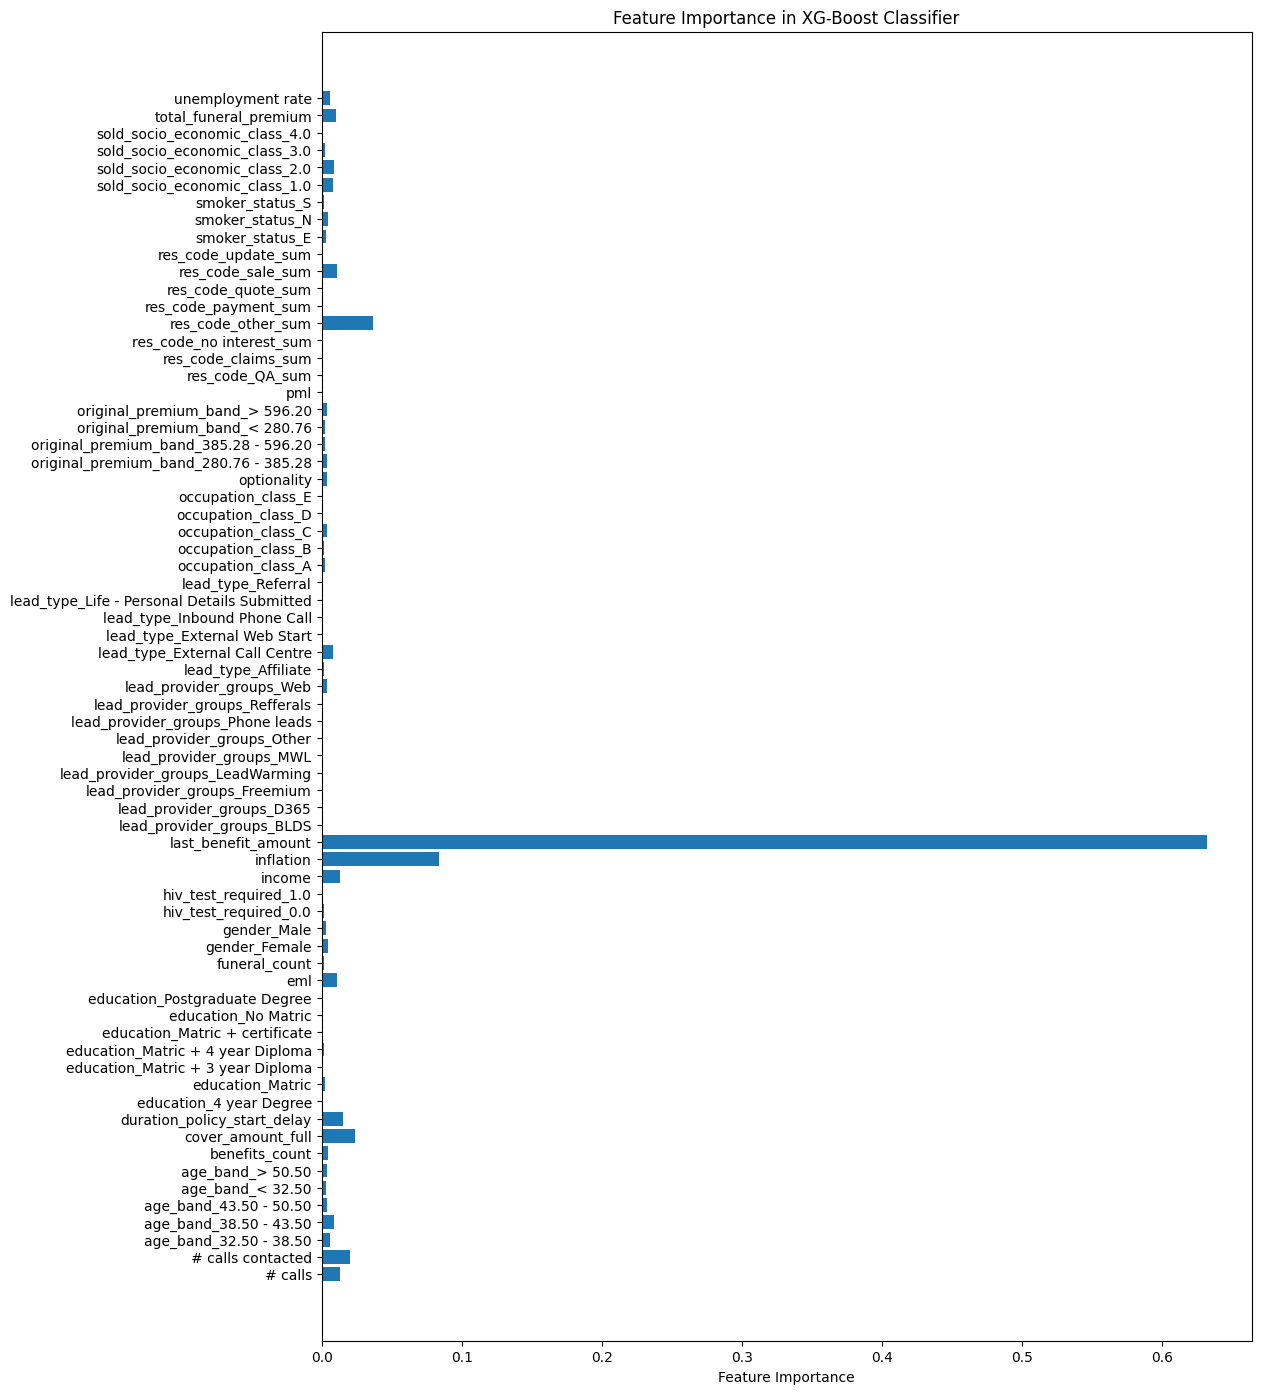

In [61]:
feature_importances =xgbc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XG-Boost Classifier')
plt.show()


#useless_feat=['securitygrup_id','sales_channel','hiv_group']

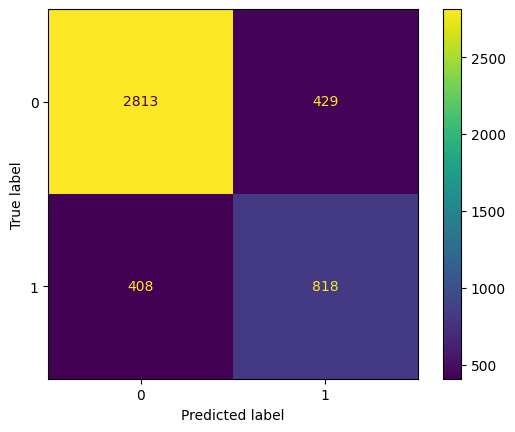

In [62]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### XGBoost, class-weight

In [ ]:
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight

In [ ]:
#X_train_n=X_train.copy()
#Y_train_n=Y_train.copy()
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer



neg_count = np.sum(Y_train == 0)
pos_count = np.sum(Y_train == 1)
scale_pos_weight_value = neg_count / pos_count

# Initialize and train the XGBClassifier with scale_pos_weight
xgb = XGBClassifier()

#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5),
              'scale_pos_weight':[scale_pos_weight_value],
              'objective':['binary:logistic']}


# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

In [ ]:
print(rand_search.best_params_ )
print(rand_search.best_score_)

{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 969, 'n_estimators': 144}
0.8882622825112051


In [ ]:
n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = XGBClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42,objective='binary:logistic', scale_pos_weight=scale_pos_weight_value)

recall = cross_val_score(xgbc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(xgbc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)


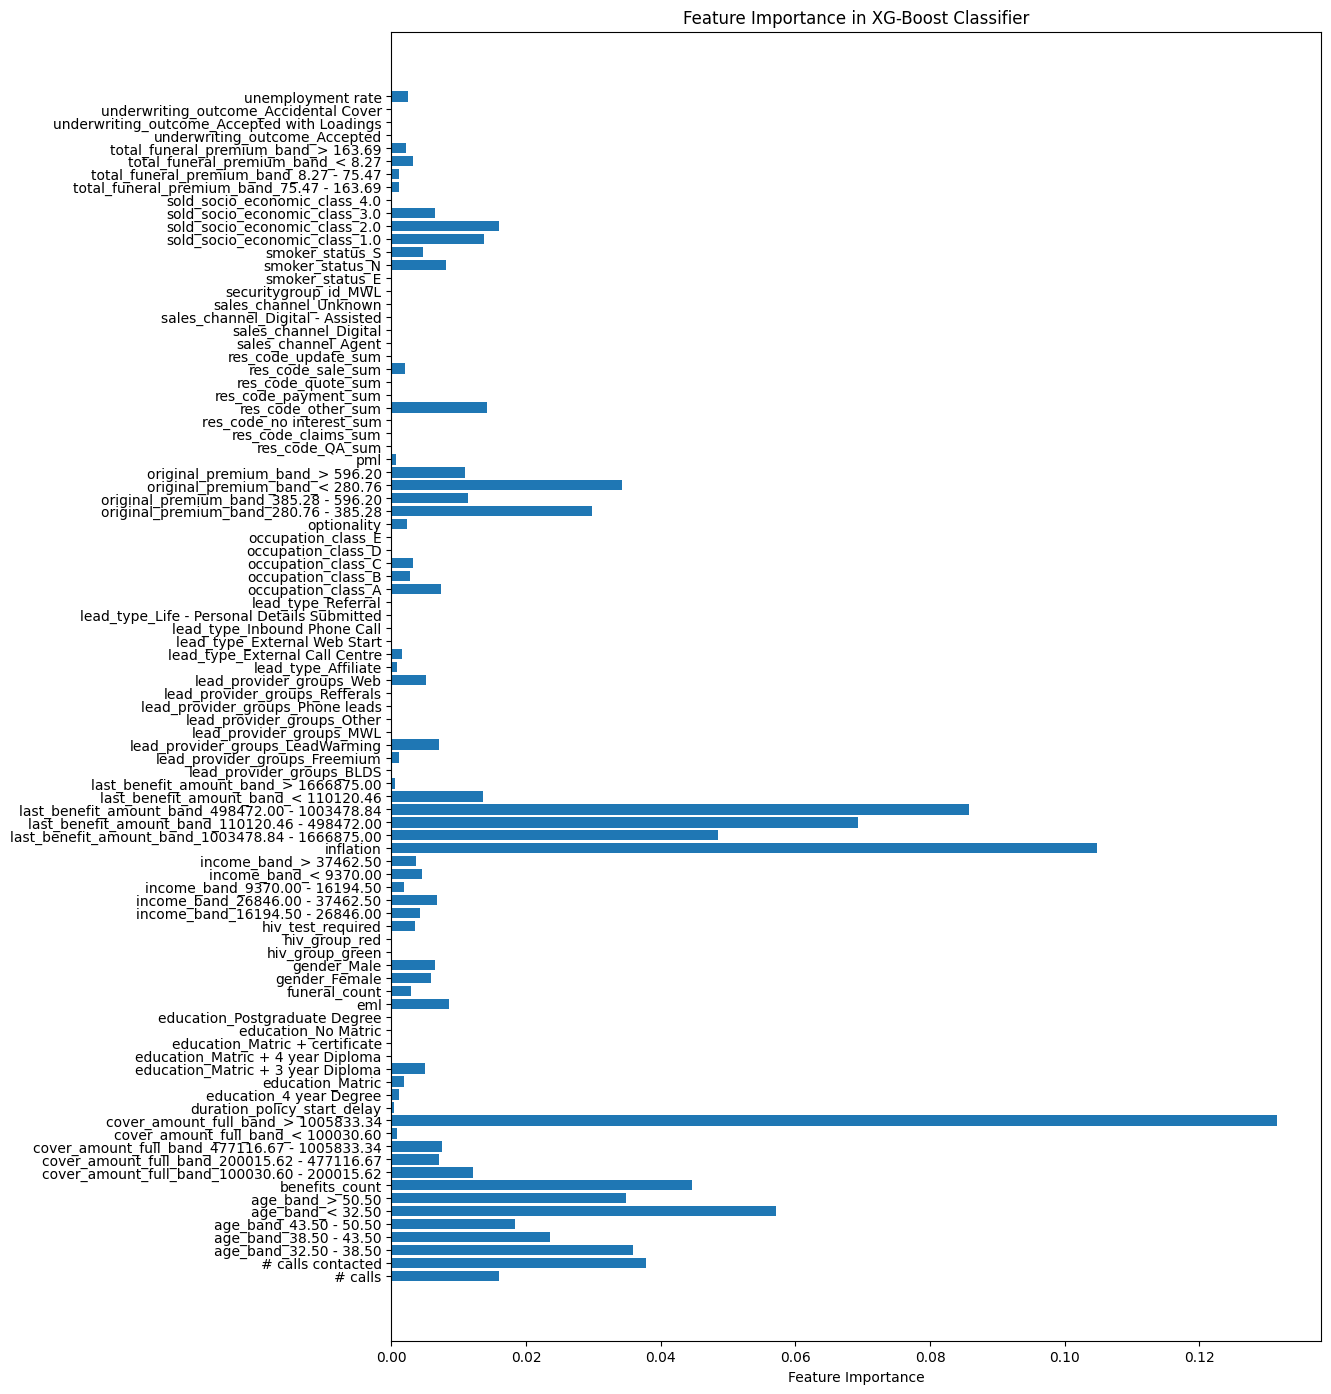

In [ ]:
feature_importances =xgbc.feature_importances_
feat_imp_df = pd.DataFrame({'variable':X_train_n.columns,'feat_imp': feature_importances})
feat_imp_df=feat_imp_df.sort_values(by='variable', ascending=True)
plt.figure(figsize=(12, 17)) 
plt.barh(feat_imp_df['variable'],feat_imp_df['feat_imp'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XG-Boost Classifier')
plt.show()


#useless_feat=['securitygrup_id','sales_channel','hiv_group']

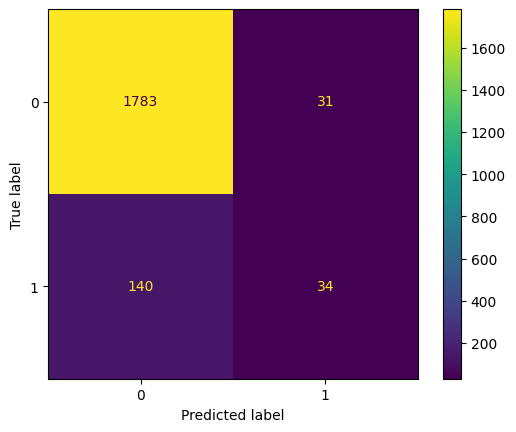

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### Excluding inflation

In [ ]:
n_estimators=241
learning_rate = 1
max_depth = 4
min_samples_leaf=1385
xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

recall = cross_val_score(xgbc, X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(xgbc,X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring='precision')
b=4
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(xgbc,X_train_n.drop(columns=['inflation']), Y_train_n, cv=5, scoring=fbeta_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

recall score [0.56097561 0.58215661 0.56418485 0.58124599 0.5973025 ]
 precision score [0.6606198  0.68556311 0.66894977 0.68045113 0.66714491]
 f beta score [0.56599749 0.5873681  0.56943068 0.58627391 0.60100357]


### SVM

In [17]:
from scipy.stats import loguniform

In [ ]:
b=4 #ratio of recall to precision
#getting best params
param_dist = {'C': loguniform(1e-3, 1e2),
              'gamma': loguniform(1e-4, 1e-1)}

# Create a random forest classifier
sv = SVC()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(sv, 
                                 param_distributions = param_dist, 
                                 n_iter=50, 
                                 cv=5,
                                 scoring='recall', random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')







In [ ]:
gamma=0.1
C = 5
svc = SVC(gamma=gamma, C=C, random_state=42)
recall = cross_val_score(svc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(svc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=2) 
fb = cross_val_score(svc,X_train_n, Y_train_n, cv=5, scoring='recall')

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}')

recall score [0.05730479 0.78162366 0.99874135 0.99811202 0.99811083]
 precision score [0.86666667 0.93594574 0.93462898 0.93404005 0.92635885]
 f beta score [0.05730479 0.78162366 0.99874135 0.99811202 0.99811083]


In [ ]:
svc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = svc.predict(x_test)

In [ ]:
feature_importances =svc.feature_importances_
plt.figure(figsize=(12, 9)) 
plt.barh(X_train_n.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest Classifier')
plt.show()

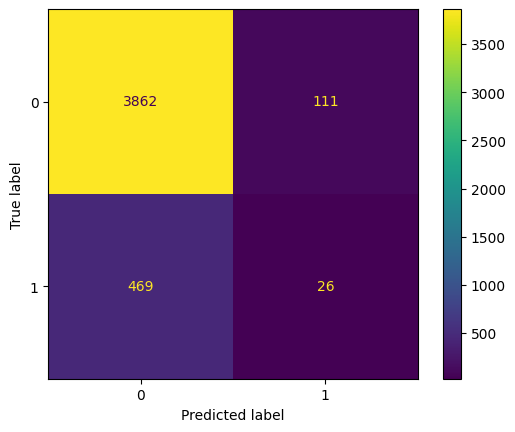

In [23]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

### NN

In [73]:
from sklearn.neural_network import MLPClassifier

from scipy.stats import loguniform

In [74]:
X_train_n=X_train.copy()#X_smote.copy()
Y_train_n=Y_train.copy()#Y_smote.copy()
scorer=custom_scorer

b=2 #ratio of recall to precision
#getting best params
param_dist = {'solver': ['adam'],
              'alpha': loguniform(1e-5, 1e-3),
              'hidden_layer_sizes': [(20,),(30,),(40,5),(35,10),(35,5),(35,),(30,5),(25,)],'max_iter':[1000]}


mlp = MLPClassifier()

# Use random search to find the best hyperparameters
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(mlp, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5,
                                 scoring=scorer, random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)
print(f'best score {rand_search.best_score_}\n best eatimator {rand_search.best_estimator_}\n best params {rand_search.best_params_}\n ')

best score 0.5405788940276907
 best eatimator MLPClassifier(alpha=0.000462258900102083, hidden_layer_sizes=(35,),
              max_iter=1000)
 best params {'alpha': 0.000462258900102083, 'hidden_layer_sizes': (35,), 'max_iter': 1000, 'solver': 'adam'}
 


In [75]:
solver='adam'
alpha=rand_search.best_params_['alpha']
hidden_layer_sizes=rand_search.best_params_['hidden_layer_sizes']

mlpc = MLPClassifier(solver=solver, alpha=alpha,max_iter=1000,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=42)
recall = cross_val_score(mlpc, X_train_n, Y_train_n, cv=5, scoring='recall')
precision = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring='precision')
fbeta_scorer = make_scorer(fbeta_score, beta=b) 
fb = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring=fbeta_scorer)
cs = cross_val_score(mlpc,X_train_n, Y_train_n, cv=5, scoring=custom_scorer)

print(f'recall score {recall}\n precision score {precision}\n f beta score {fb}\n custom score {cs}')

recall score [0.37414966 0.36432351 0.38170824 0.32753404 0.4311649 ]
 precision score [0.54395604 0.51113468 0.51217039 0.5392279  0.51075269]
 f beta score [0.39906482 0.38652767 0.40219815 0.35544246 0.44503435]
 custom score [0.52131227 0.50794972 0.51657789 0.4968989  0.53992365]


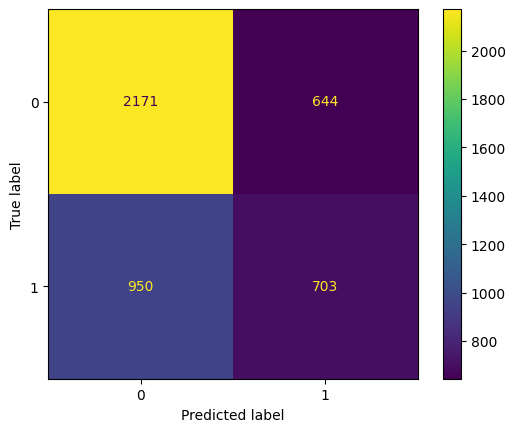

In [76]:
mlpc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = mlpc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()